## Simulación de MonteCarlo

Los activos elegidos para formar nuestra cartera han sido:

PG → Procter & Gamble Co.

CRM → Salesforce, Inc.

DIS → The Walt Disney Company

In [17]:
import numpy as np
from numpy.linalg import cholesky

In [18]:
def MonteCarlo(initial_maturity, S_0, num_sims, num_assets, num_asian_dates, value_date_index, correl_matrix,risk_free_rate, vols):
    '''
  Inputs:
  -------
  * S_0 (float): initial spot prices of the assets
  * num_asian_dates (int): number of asian dates. Notice that this includes the initial date, which fixes the initial spot values.
  * value_date_index (int): index, within the array of asian dates indicating the value date. (Actual step)
  * risk_free_rate (float): risk free rate
  * num_assets (int): number of underlying assets.
  * vols (array(float)): array of indiv assets vols.
  * correl_matrix (array(float, float)): matrix of correlations
  * initial_maturity (float): maturity of the product as seen on initial spot fixing date. (Years)
  * num_sims (int): number of simulations
  Outputs:
  --------
  * rets (numpy.ndarray): simulation of the evolution of the assets. Shape (num_sims, num_asian_dates-1, num_assets)
  * payoff (numpy.ndarray): Payoff of every simulation done. Shape (num_sims, )
  * premium (numpy.float64): present value in the actual step given by value_date_index.
  '''

    # Inputs:

    # Simulation of assets up to value date:

    init_time_array = np.linspace(0, initial_maturity, num_asian_dates)

    delta_t = initial_maturity / (num_asian_dates - 1)
    num_steps = value_date_index
    num_remaining_steps = num_asian_dates - value_date_index -1

    # Independent brownians
    inc_W = np.random.normal(size=(num_assets, num_steps), scale = np.sqrt(delta_t))

    # Cholesky matrix
    m = cholesky(correl_matrix)

    # Correlated brownians
    inc_W_correl = np.matmul(m, inc_W)

    # Independent brownian motion (the axis order is done to be able to correlate them with a matrix multiplication)
    inc_W_remaining = np.random.normal(size=(num_sims, num_remaining_steps, num_assets), scale = np.sqrt(delta_t))

    # We correlate them
    inc_W_correl_remaining = np.matmul(inc_W_remaining, m.T)

    # We transpose the 3D matrix of correlated B. motion (path, asset, time step)

    inc_W_correl_remaining = inc_W_correl_remaining.transpose([0,2,1])

    aux = np.repeat(inc_W_correl[None,...],num_sims,axis=0)

    # We attach the brownians obtained from t= 0 to value date

    inc_W_correl_total = np.concatenate((aux, inc_W_correl_remaining), axis = 2)

    # We compute exponential returns

    gross_rets_total = np.exp((risk_free_rate - 0.5 *vols **2) * delta_t + vols * inc_W_correl_total)

    # We simulate the underlyings

    S_T = np.cumprod(np.concatenate((np.repeat(S_0.reshape(-1,1)[None,...],num_sims,axis=0), gross_rets_total), axis = 2), axis = 2)

    # We compute the returns

    rets = S_T[:,:,1:] / np.repeat(S_0.reshape(-1,1)[None,...],num_sims,axis=0)

    payoff = np.maximum(np.sum(np.prod(rets, axis = (2))**(1/(num_assets * (num_asian_dates-1))), axis = 1)-3,0)

    # Calculate the premium as the discounted average value

    premium = np.mean(payoff*np.exp(-risk_free_rate*(initial_maturity-init_time_array[value_date_index])))

    rets = rets.transpose([0,2,1])

    return rets, payoff, premium

In [19]:
S_0 = np.array([1,1,1])
num_steps = 20
vols = np.array([0.29,0.38,0.33]).reshape(-1,1)
risk_free_rate = 0.01


TTM = initial_maturity = 5 #years
value_date_index = 5 #actual step
num_asian_dates = num_steps + 1 #Time steps + 1
init_time_array = np.linspace(0, initial_maturity, num_asian_dates)

rho = 0.1
correl_matrix = rho = np.array([
    [1, 0.275125, 0.329366],
    [0.275125, 1, 0.381295],
    [0.329366, 0.381295, 1]
]) 


num_sims = 100000

num_assets = 3 #numero de activos

rets, payoff, premium = MonteCarlo(initial_maturity, S_0, num_sims, num_assets, num_asian_dates, value_date_index, correl_matrix,risk_free_rate, vols)

In [20]:
print(rets)

[[[0.85573127 0.96924832 1.24146327]
  [1.00158083 1.04115819 1.5098598 ]
  [1.16004432 1.0204133  1.62233898]
  ...
  [0.976757   0.90227535 0.88568763]
  [0.91675493 1.12009724 0.98186225]
  [0.78215896 1.23721569 0.83581153]]

 [[0.85573127 0.96924832 1.24146327]
  [1.00158083 1.04115819 1.5098598 ]
  [1.16004432 1.0204133  1.62233898]
  ...
  [1.61357489 1.30622905 1.69552469]
  [1.61827597 1.60040278 1.62636733]
  [1.42848126 1.67437242 1.68815395]]

 [[0.85573127 0.96924832 1.24146327]
  [1.00158083 1.04115819 1.5098598 ]
  [1.16004432 1.0204133  1.62233898]
  ...
  [0.71629448 0.59099308 1.9447341 ]
  [0.68220946 0.77085705 1.88485168]
  [0.71823071 0.72322813 1.9401624 ]]

 ...

 [[0.85573127 0.96924832 1.24146327]
  [1.00158083 1.04115819 1.5098598 ]
  [1.16004432 1.0204133  1.62233898]
  ...
  [0.72284722 0.44743371 1.25845306]
  [0.68127983 0.43447663 1.44029552]
  [0.63127304 0.29423642 1.25106509]]

 [[0.85573127 0.96924832 1.24146327]
  [1.00158083 1.04115819 1.5098598 ]


In [21]:
print(premium)

0.09131518841125034


### Valor presente

Dados todos los timesteps:

In [22]:
#present_value (numpy.ndarray): present value of the payoff in every time step. Shape (num_sims, num_asian_dates-1)

time_array = np.linspace(0, initial_maturity, num_steps)

present_value = np.matmul(payoff.reshape(-1,1),np.exp(- risk_free_rate*(initial_maturity-time_array )).reshape(1,-1))

In [23]:
print(present_value)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.17361096 0.17406843 0.17452711 ... 0.18155411 0.18203252 0.18251218]
 [0.06396712 0.06413567 0.06430467 ... 0.06689378 0.06707005 0.06724678]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.02726378 0.02733562 0.02740765 ... 0.02851117 0.0285863  0.02866163]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## Formula cerrada

Let's assume that:

$$S_T^j=S_t^j\exp\left(\left(r-\sigma_j^2/2\right)\left(t_n-t\right)+\sigma_i\left(W^j_T-W^j_t\right)\right)$$

And that the different underlyings are correlated with correlations $\rho_{ij}$.

We are interested in the following expected value

$$V_{t_v}=E\left[\left(\left(\prod_{i=1}^{n}\prod_{j=1}^{m}\frac{S_{t_i}^j}{S_{t_0}^j}\right)^{\frac{1}{nm}}-1\right)^+\exp\left(-r\left(t_n-t_v\right)\right)\Bigg{|}\mathcal{F}_{t_v}\right]$$

Where $\mathcal{F}_t$ represents that $S^j_{t_i}$ has been observed $\forall j$ and $t_i,\ \ i=0,\ldots,v$


$$V_{t_v}=E\left[\left(\left(\prod_{i=1}^{v}\prod_{j=1}^{m}\frac{S_{t_i}^j}{S_{t_0}^j}\right)^{\frac{1}{nm}}\left(\prod_{i=v+1}^{n}\prod_{j=1}^{m}\frac{S_{t_i}^j}{S_{t_0}^j}\right)^{\frac{1}{nm}}-1\right)^+\exp\left(-r\left(t_n-t_v\right)\right)\Bigg{|}\mathcal{F}_{t_v}\right]$$

Conditioned on $\mathcal{F}_t$, the term $\prod_{i=v+1}^{n}\prod_{j=1}^{m}\frac{S_{t_i}^j}{S_{t_0}^j}$ is the only stochastic term inside the expected value. Since under Black Scholes dynamics this term is the product of variables lognormally distributed, it is itself lognormal. Therefore, in order to derive the expression of the expected value we should derive the expression of the expected value and the variance of the logarithm of this term.


In [24]:
from scipy.stats import norm

N = norm.cdf

def Black(Forward, Strike, TTM, rate, Vol, IsCall):

  '''
  Inputs:
  -------
    Forward (float): Forward value
    Strike (float): strike price
    TTM (float): time to maturity in years
    rate (float): risk free rate
    Vol (float): volatility
    IsCall (bool): True if call option, False if put option
  Outputs:
  --------
    Option premium (float)
  '''

  if TTM >0:

    d1 = (np.log(Forward/Strike) + (Vol*Vol/2)*TTM)/(Vol*np.sqrt(TTM))
    d2 = (np.log(Forward/Strike) + (- Vol*Vol/2)*TTM)/(Vol*np.sqrt(TTM))

    if IsCall:

      return (Forward*N(d1)-Strike*N(d2))*np.exp(-rate*TTM)

    else:

      return (-Forward*N(-d1)+Strike*N(-d2))*np.exp(-rate*TTM)

  else:

    if IsCall:

      return np.maximum(Forward-Strike,0)

    else:

      return np.maximum(-Forward+Strike,0)

In [25]:
def BasketGeomAsian(num_asian_dates, value_date_index, risk_free_rate, num_assets, assets_vol, assets_correl, initial_maturity, price_history, IsCall):
  '''
  Inputs:
  -------
  * num_asian_dates (int): number of asian dates. Notice that this includes the initial date, which fixes the initial spot values.
  * value_date_index (int): index, within the array of asian dates indicating the value date.
  * risk_free_rate (float): risk free rate
  * num_assets (int): number of underlying assets.
  * assets_vol (array(float)): array of indiv assets vols.
  * assets_correl (array(float, float)): matrix of correlations
  * initial_maturity (float): maturity of the product as seen on initial spot fixing date.
  * price_history (array(float, float)): history of fixings of the underlyings up to value date. Assets per row, time steps per column.
  * IsCall (bool): True if call option, False if put option
  Outputs:
  --------
  * Option price (float)
  '''

  init_time_array = np.linspace(0, initial_maturity, num_asian_dates)

  pending_times_array = init_time_array[value_date_index+1:] - init_time_array[value_date_index]

  mu = np.sum(risk_free_rate - 0.5*assets_vol*assets_vol)*np.sum(pending_times_array) / (num_assets * (num_asian_dates-1))

  diag_vol = np.diag(assets_vol.reshape(-1))

  cov_matrix = np.matmul(diag_vol, np.matmul(assets_correl, diag_vol))

  xx, yy = np.meshgrid(pending_times_array, pending_times_array, sparse=True)
  z = np.minimum(xx, yy)

  V = np.sum(cov_matrix) * np.sum(z) / (num_assets*num_assets*(num_asian_dates-1)*(num_asian_dates-1))

  Forward = np.power(np.prod(price_history[:, 1:value_date_index+1] / price_history[:,0].reshape(-1,1)),1.0/(num_assets * (num_asian_dates-1)))

  Forward *= np.power(np.prod(price_history[:,value_date_index] / price_history[:,0]), (num_asian_dates-value_date_index-1)/(num_assets * (num_asian_dates-1)))

  Forward *= np.exp(mu + 0.5 * V)

  remaining_maturity = initial_maturity - init_time_array[value_date_index]


  return Black(Forward, 1.0, remaining_maturity, risk_free_rate,np.sqrt(V / remaining_maturity), IsCall)


##  Comparando Simulación y Formula cerrada

In [26]:
import random
premium_20 = []
analytics_20 = []
for i in np.arange(1,20):
  random.seed(77)
  simu, payoff, premium = MonteCarlo(initial_maturity, S_0, num_sims, num_assets, num_asian_dates, i, correl_matrix,risk_free_rate, vols)

  simu2 = simu.transpose([0,2,1])

  analytic = BasketGeomAsian(num_asian_dates, i, risk_free_rate, num_assets, vols, correl_matrix, initial_maturity, simu2[1,:,:(i+1)], True)
  premium_20.append(premium)
  analytics_20.append(analytic)

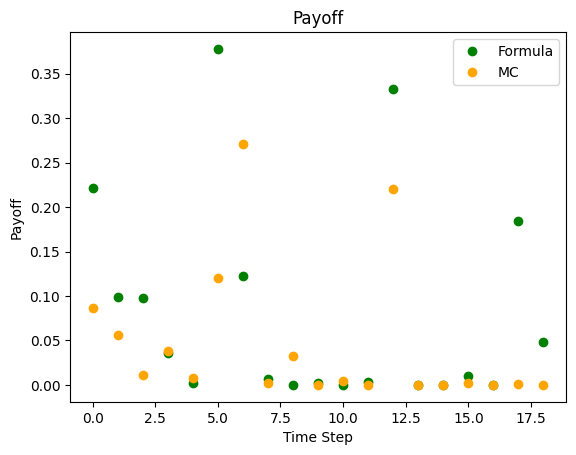

In [27]:
import matplotlib.pyplot as plt
plt.plot(analytics_20,"o", color='green', label='Formula')
plt.plot(premium_20,"o", color='orange', label='MC')
plt.legend()
plt.title("Payoff")
plt.xlabel('Time Step')
plt.ylabel('Payoff')
plt.show()